In [1]:
import numpy
import transformers
import datasets

print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.1.2
4.49.0
3.4.1


In [2]:
import numpy as np
import torch
from evaluate import load  

In [5]:

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from evaluate import load as load_metric 

dataset = load_dataset("nsmc")
print(dataset)



DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def clean_document(example):
    if example['document'] is None:
        example['document'] = ""
    # 한글, 영어, 숫자, 기본 특수문자, 띄어쓰기 
    example['document'] = re.sub(r"[^가-힣a-zA-Z0-9\s\.\,\!\?\:\;\(\)\'\"\-]", "", example['document'])
    return example

# 데이터셋에 정제 함수 적용
dataset = dataset.map(clean_document)

In [6]:
# 모델과 Tokenizer 불러오기
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

# Tokenization 함수 정의 (문서 길이를 max_length로 padding)
def tokenize_function(example):
    return tokenizer(example['document'], truncation=True, padding='max_length')



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# 전체 데이터셋에 Tokenization 적용
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# 데이터셋 크기 제한
small_train_dataset = tokenized_dataset["train"].select(range(30000))
small_val_dataset = tokenized_dataset["train"].select(range(30000, 35000))
small_test_dataset = tokenized_dataset["test"].select(range(5000))

In [8]:
# 데이터셋 상위 5개 출력
print("Train Dataset Sample")
for element in small_train_dataset[:5].values():
    print(element)
print('\n')

print("Validation Dataset Sample")
for element in small_val_dataset[:5].values():
    print(element)
print('\n')

print("Test Dataset Sample")
for element in small_test_dataset[:5].values():
    print(element)
print('\n')

Train Dataset Sample
['9976970', '3819312', '10265843', '9045019', '6483659']
['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']
[0, 1, 0, 0, 1]
[[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [4]:
import numpy as np
from transformers import TrainingArguments, Trainer

# 평가 metric: accuracy
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.evaluate(eval_dataset=small_test_dataset)



C:\Users\yss63\anaconda3\envs\my_new_env\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.306000,0.287681,0.885200
2,0.210300,0.358968,0.892000
3,0.132900,0.500648,0.892200


{'eval_loss': 0.4730643630027771,
 'eval_accuracy': 0.8932,
 'eval_runtime': 42.7757,
 'eval_samples_per_second': 116.889,
 'eval_steps_per_second': 9.749,
 'epoch': 3.0}

In [9]:
def tokenize_function2(examples):
    return tokenizer(
        examples["document"],
        truncation=True,
        # 동적 패딩을 적용하기 때문에 max_length는 크게 잡음
        max_length=512,
    )

In [10]:
tokenized_dataset2 = dataset.map(tokenize_function2, batched=True)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [12]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer, DataCollatorWithPadding)
# 동적 패딩
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [13]:
training_args = TrainingArguments(
    output_dir="./results_bucketing",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    num_train_epochs=3,
    weight_decay=0.01,
    group_by_length=True,  # Bucketing 활성화
    logging_steps=100,
)


C:\Users\yss63\anaconda3\envs\my_new_env\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_val_dataset,
    tokenizer=tokenizer,            
    data_collator=data_collator,     # 동적 패딩 적용
    compute_metrics=compute_metrics, 
)

C:\Users\yss63\AppData\Local\Temp\ipykernel_3268\457295174.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()
eval_results = trainer.evaluate(eval_dataset=small_test_dataset)
print(eval_results)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.304700,0.290947,0.887200
2,0.182300,0.395475,0.887800
3,0.153500,0.490593,0.892600


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Evaluation Results: {'eval_loss': 0.4737555682659149, 'eval_accuracy': 0.8902, 'eval_runtime': 44.4295, 'eval_samples_per_second': 112.538, 'eval_steps_per_second': 9.386, 'epoch': 3.0}


In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    "klue/bert-base", 
    num_labels=2,
    hidden_dropout_prob=0.2, 
    attention_probs_dropout_prob=0.2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
training_args = TrainingArguments(
    output_dir="./results_bucketing_lr_decay",
    evaluation_strategy="epoch",
    learning_rate=2e-5,  # 초기 러닝레이트 설정
    lr_scheduler_type="cosine",  # 러닝레이트 감소 적용
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    num_train_epochs=3,
    weight_decay=0.01,
    group_by_length=True)

C:\Users\yss63\anaconda3\envs\my_new_env\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [25]:

trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy
1,0.321700,0.306736,0.881600
2,0.259200,0.342234,0.885400
3,0.203000,0.405003,0.886200


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


NameError: name 'test_dataset' is not defined

In [26]:
eval_result = trainer.evaluate(eval_dataset=small_test_dataset)
print( eval_result)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 0.38360852003097534, 'eval_accuracy': 0.8898, 'eval_runtime': 47.0188, 'eval_samples_per_second': 106.34, 'eval_steps_per_second': 8.869, 'epoch': 3.0}


## 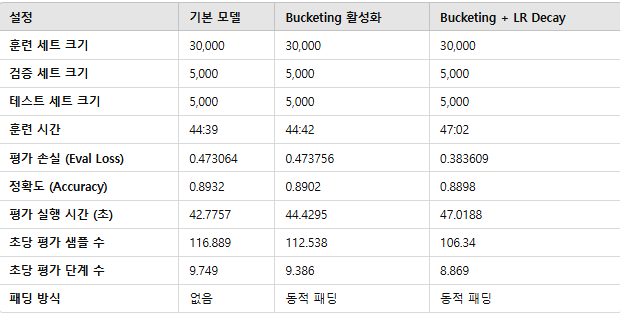

### 기본 모델 (동적 패딩 없음, Bucketing 없음, LR Decay 없음)
    => Training Loss가 점진적으로 감소하지만, Validation Loss는 Epoch이 지날수록 증가
       과적합으로 추정되지만 0.892200의 accuracy

### Bucketing 활성화 모델 
    => 마찬가지로 Training Loss가 점진적으로 감소하지만, Validation Loss는 Epoch이 지날수록 증가
    여전히 과적합으로 추정, 0.892600의 accuracy
    
### Bucketing + LearningRate Decay, dropout 추가 모델
    =>Training Loss는 줄었지만 상대적으로 높은 값 유지, Validation Loss 증가도 덜함
    Eval Loss가 가장 낮아 일반화 성능이 가장 좋을 가능성이 있음, 0.886200의 accuracy 

    


생각보다 bucketing과 일반 모델의 모델 성능 향상과 훈련 시간의 차이는 없었음...

LR Decay, dropout모델과 비교해봐도 눈에띄는 성능 향상은 없었고  훈련 시간은 오히려 증가

In [ ]:
입력 데이터의 길이 분포가 상대적으로 균일하다면, Bucketing을 적용해도 성능 향상이 크지 않을것이라고 생각해서 데이터 길이를 찍어봤는데 
대부분의 샘플이 20~40 토큰 사이에 몰려 있음



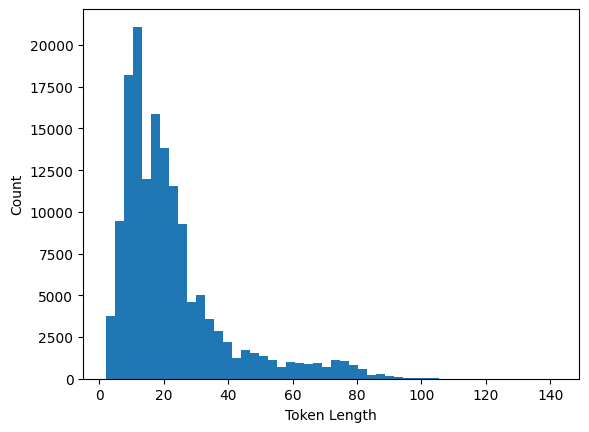

In [32]:
import matplotlib.pyplot as plt


lengths = [len(tokenizer.encode(example["document"])) for example in dataset["train"]]
plt.hist(lengths, bins=50)
plt.xlabel("Token Length")
plt.ylabel("Count")
plt.show()

NameError: name 'd' is not defined